**Część pierwsza - przygotowanie danych**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Ustawienie stylu wykresów
sns.set(style="whitegrid")

# 1.1. Załaduj zbiór danych Wine [cite: 5, 10]
data = load_wine()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# 1.2. Wyświetl liczbę próbek, cech i rozkład klas [cite: 6, 11]
print("### CZĘŚĆ 1: STATYSTYKI ###")
print(f"Liczba próbek: {X.shape[0]}")
print(f"Liczba cech: {X.shape[1]}")
print(f"Nazwy cech: {feature_names}")

# Rozkład klas
class_counts = pd.Series(y).value_counts().sort_index()
class_counts.index = target_names
print("\nRozkład klas:")
print(class_counts)

# 1.3. Przeprowadź standaryzację [cite: 12]
# Wyjaśnienie: Standaryzacja wyrównuje wpływ cech o różnych skalach (np. Prolina vs Fenole)[cite: 41].
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print("\nStandaryzacja zakończona (średnia=0, odchylenie=1).")

### CZĘŚĆ 1: STATYSTYKI ###
Liczba próbek: 178
Liczba cech: 13
Nazwy cech: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

Rozkład klas:
class_0    59
class_1    71
class_2    48
Name: count, dtype: int64

Standaryzacja zakończona (średnia=0, odchylenie=1).


Standaryzacja przed PCA jest konieczna, ponieważ algorytm PCA jest wrażliwy na skalę danych. Bez standaryzacji cechy o dużych wartościach liczbowych zdominowałyby wynik analizy nad cechami o małych wartościach. Proces ten wyrównuje wpływ wszystkich zmiennych, pozwalając algorytmowi oceniać rzeczywistą strukturę danych, a nie różnice wynikające jedynie z jednostek miary.

**Część druga - wykonanie PCA**

In [3]:
from sklearn.decomposition import PCA

# 2.1. Wykonaj PCA (wszystkie składowe) [cite: 14]
pca = PCA()
X_pca = pca.fit_transform(X_std)

# 2.2. Wyświetl: wartości własne, % wyjaśnionej wariancji, skumulowaną wariancję [cite: 15]
eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

df_pca_stats = pd.DataFrame({
    'Składowa (PC)': [f'PC{i+1}' for i in range(len(feature_names))],
    'Wartość własna': eigenvalues,
    'Wyjaśniona wariancja (%)': np.round(explained_variance_ratio * 100, 2),
    'Skumulowana wariancja (%)': np.round(cumulative_variance * 100, 2)
})

print("\n### CZĘŚĆ 2: WYNIKI PCA ###")
print(df_pca_stats.head(13).to_string(index=False))

# 2.3. Ile składowych potrzeba dla >80% wariancji? [cite: 16]
# Szukam progu 80% lub 95% zgodnie ze wskazówkami [cite: 42]
n_components_80 = np.argmax(cumulative_variance > 0.80) + 1
print(f"\nLiczba składowych potrzebna do wyjaśnienia >80% wariancji: {n_components_80}")


### CZĘŚĆ 2: WYNIKI PCA ###
Składowa (PC)  Wartość własna  Wyjaśniona wariancja (%)  Skumulowana wariancja (%)
          PC1        4.732437                     36.20                      36.20
          PC2        2.511081                     19.21                      55.41
          PC3        1.454242                     11.12                      66.53
          PC4        0.924166                      7.07                      73.60
          PC5        0.858049                      6.56                      80.16
          PC6        0.645282                      4.94                      85.10
          PC7        0.554141                      4.24                      89.34
          PC8        0.350466                      2.68                      92.02
          PC9        0.290512                      2.22                      94.24
         PC10        0.252320                      1.93                      96.17
         PC11        0.227064                      1.74   

**Część trzecia - wizualizacja**

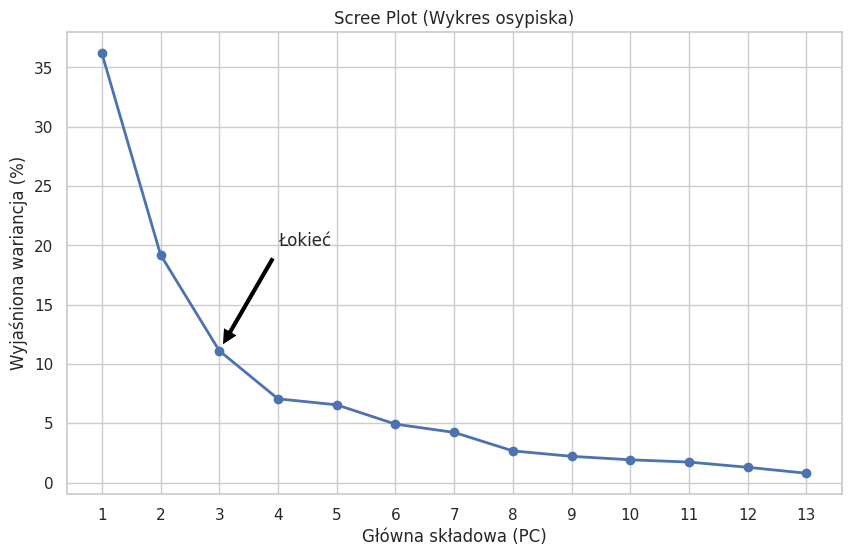

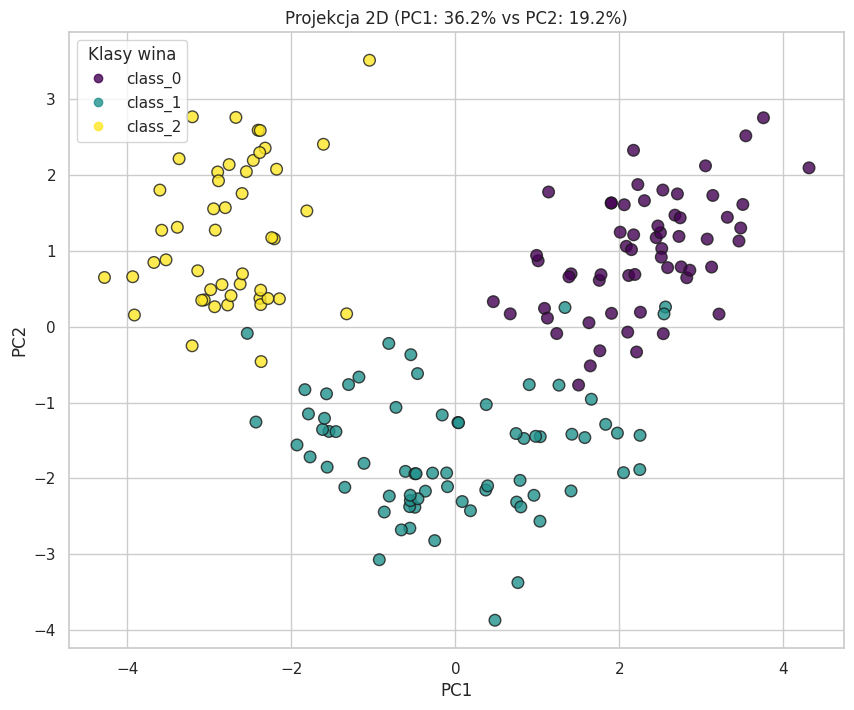

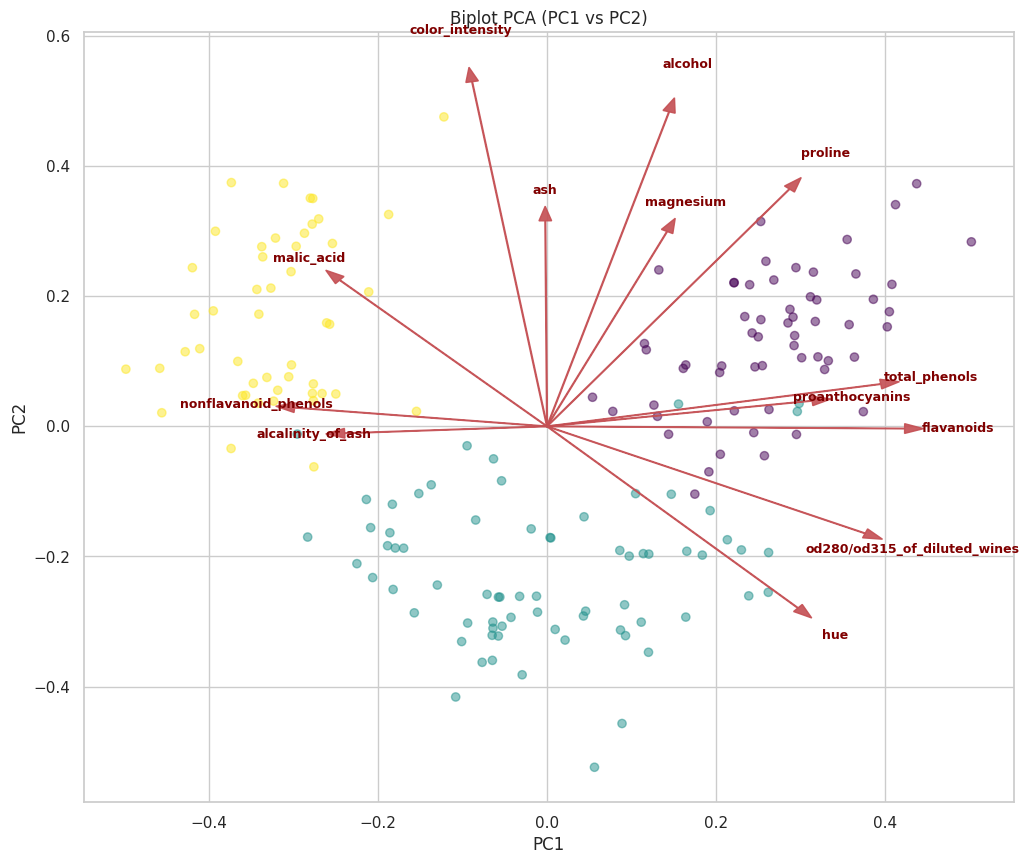

In [4]:
# 3.1. Scree Plot - zaznacz "łokieć" [cite: 19]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 'bo-', linewidth=2)
plt.title('Scree Plot (Wykres osypiska)')
plt.xlabel('Główna składowa (PC)')
plt.ylabel('Wyjaśniona wariancja (%)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Automatyczne zaznaczenie łokcia (subiektywnie w okolicach 3 składowej)
plt.annotate('Łokieć', xy=(3, explained_variance_ratio[2]*100), xytext=(4, 20),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# 3.2. Projekcja 2D (PC1 vs PC2) z kolorami klas [cite: 20]
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=70, alpha=0.8)
plt.title(f'Projekcja 2D (PC1: {explained_variance_ratio[0]*100:.1f}% vs PC2: {explained_variance_ratio[1]*100:.1f}%)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Klasy wina")
plt.grid(True)
plt.show()

# 3.3. Biplot - punkty danych + wektory cech [cite: 21]
def draw_biplot(score, coeff, labels=None, targets=None):
    plt.figure(figsize=(12, 10))
    xs = score[:, 0]
    ys = score[:, 1]

    # Skalowanie wektorów do zakresu punktów dla lepszej widoczności [cite: 43]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    # Rysowanie punktów
    plt.scatter(xs * scalex, ys * scaley, c=targets, cmap='viridis', alpha=0.5)

    # Rysowanie wektorów cech
    n = coeff.shape[0]
    for i in range(n):
        # Rysujemy strzałki
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.9, head_width=0.015)
        # Dodajemy etykiety cech
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='maroon', ha='center', va='center', fontsize=9, weight='bold')

    plt.title('Biplot PCA (PC1 vs PC2)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)

# Uruchomienie funkcji Biplot
draw_biplot(X_pca, pca.components_.T, labels=feature_names, targets=y)
plt.show()

**Część czwarta - interpretacja**

In [5]:
# --- 4.1 Wyświetl ładunki (loadings) dla PC1 i PC2 ---
# Tworzę DataFrame dla czytelności
loadings = pd.DataFrame(
    pca.components_.T,  # Transpozycja macierzy komponentów
    columns=[f'PC{i+1}' for i in range(len(feature_names))],
    index=feature_names
)

# Wybieram tylko PC1 i PC2
loadings_pc1_pc2 = loadings[['PC1', 'PC2']]

print("### ŁADUNKI (LOADINGS) DLA PC1 i PC2 ###")
print(loadings_pc1_pc2)

print("\n--- Najważniejsze cechy dla PC1 (posortowane wg siły wpływu) ---")
# Sortuję wg wartości bezwzględnej, aby znaleźć najsilniejsze korelacje
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))

print("\n--- Najważniejsze cechy dla PC2 (posortowane wg siły wpływu) ---")
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))

### ŁADUNKI (LOADINGS) DLA PC1 i PC2 ###
                                   PC1       PC2
alcohol                       0.144329  0.483652
malic_acid                   -0.245188  0.224931
ash                          -0.002051  0.316069
alcalinity_of_ash            -0.239320 -0.010591
magnesium                     0.141992  0.299634
total_phenols                 0.394661  0.065040
flavanoids                    0.422934 -0.003360
nonflavanoid_phenols         -0.298533  0.028779
proanthocyanins               0.313429  0.039302
color_intensity              -0.088617  0.529996
hue                           0.296715 -0.279235
od280/od315_of_diluted_wines  0.376167 -0.164496
proline                       0.286752  0.364903

--- Najważniejsze cechy dla PC1 (posortowane wg siły wpływu) ---
flavanoids                      0.422934
total_phenols                   0.394661
od280/od315_of_diluted_wines    0.376167
proanthocyanins                 0.313429
nonflavanoid_phenols            0.298533
Na

* **Które cechy dominują w PC1? Co reprezentuje ta składowa?**
W PC1 rządzą flawonoidy i fenole (wszystkie wartości > 0.35). Ta składowa to w skrócie "skład chemiczny" wina. Mówi nam, jak bardzo wino jest bogate w związki organiczne.

* **Które cechy dominują w PC2?**
W PC2 najważniejszy jest kolor (intensywność) i alkohol. To jest oś, która odróżnia wina ciemne i mocne od tych jaśniejszych i słabszych.

* **Czy klasy są dobrze separowalne w 2D?**
Widać trzy grupy, ale nie jest idealnie. Jedna klasa odstaje wyraźnie, ale dwie pozostałe trochę na siebie zachodzą. Dwa wymiary (PC1 i PC2) to za mało, żeby je perfekcyjnie oddzielić.